<a href="https://colab.research.google.com/github/mertkayaozkann/sondan-bir-nceki-hali/blob/main/fine_tuning_LLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
torch.cuda.is_available()

True

In [ ]:
!pip install transformers datasets accelerate

In [ ]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel

# Tokenizer ve model yükleniyor
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
!pip install -U datasets

In [ ]:
from datasets import load_dataset

raw_datasets = load_dataset("daily_dialog")
print(raw_datasets["train"][0])

{'dialog': ['Say , Jim , how about going for a few beers after dinner ? ', ' You know that is tempting but is really not good for our fitness . ', ' What do you mean ? It will help us to relax . ', " Do you really think so ? I don't . It will just make us fat and act silly . Remember last time ? ", " I guess you are right.But what shall we do ? I don't feel like sitting at home . ", ' I suggest a walk over to the gym where we can play singsong and meet some of our friends . ', " That's a good idea . I hear Mary and Sally often go there to play pingpong.Perhaps we can make a foursome with them . ", ' Sounds great to me ! If they are willing , we could ask them to go dancing with us.That is excellent exercise and fun , too . ', " Good.Let ' s go now . ", ' All right . '], 'act': [3, 4, 2, 2, 2, 3, 4, 1, 3, 4], 'emotion': [0, 0, 0, 0, 0, 0, 4, 4, 4, 4]}


In [ ]:
# 1. Bir preprocessing fonksiyonu tanımla
def preprocess_dialog(example):
    # Her alternatifi Speaker1 / Speaker2 olarak etiketleyelim
    turns = []
    for idx, utt in enumerate(example["dialog"]):
        speaker = "Speaker1" if idx % 2 == 0 else "Speaker2"
        # strip() ile baştaki/sondaki boşlukları temizle
        turns.append(f"{speaker}: {utt.strip()}")
    # Satır satır birleştir
    text = "\n".join(turns)
    return {"text": text}

# 2. Tüm train ve validation split'lerine uygula
processed_datasets = raw_datasets.map(
    preprocess_dialog,
    remove_columns=["dialog"],   # artık orijinal 'dialog' alanına ihtiyacımız yok
    batched=False                # örnek bazlı dönüşüm
)

# 3. İşlenmiş ilk örneği görüntüle
print(processed_datasets["train"][0]["text"])

Speaker1: Say , Jim , how about going for a few beers after dinner ?
Speaker2: You know that is tempting but is really not good for our fitness .
Speaker1: What do you mean ? It will help us to relax .
Speaker2: Do you really think so ? I don't . It will just make us fat and act silly . Remember last time ?
Speaker1: I guess you are right.But what shall we do ? I don't feel like sitting at home .
Speaker2: I suggest a walk over to the gym where we can play singsong and meet some of our friends .
Speaker1: That's a good idea . I hear Mary and Sally often go there to play pingpong.Perhaps we can make a foursome with them .
Speaker2: Sounds great to me ! If they are willing , we could ask them to go dancing with us.That is excellent exercise and fun , too .
Speaker1: Good.Let ' s go now .
Speaker2: All right .


In [ ]:
# —— Hücre 1 ——


# 0️⃣ Pad‐token ayarı (sadece GPT-2 için)
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = model.config.eos_token_id

# 1️⃣ Tokenizasyon
block_size = 128
def tokenize_fn(examples):
    return tokenizer(
        examples["text"],
        truncation=True,
        max_length=block_size,
        padding="max_length",
    )

tokenized = processed_datasets.map(
    tokenize_fn,
    batched=True,
    remove_columns=["text"]
)

# 2️⃣ DataCollator (Causal LM)
from transformers import DataCollatorForLanguageModeling
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False
)

print("✅ Tokenization and data_collator ready!")


✅ Tokenization and data_collator ready!


In [ ]:
!pip install -U transformers

In [ ]:
!pip install --upgrade transformers

In [ ]:
!pip install -qU transformers datasets accelerate

In [ ]:
import transformers
print(transformers.__version__)  # >=4.6 olmalı

4.51.3


In [ ]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./gpt2-dailydialog",
    num_train_epochs=3,
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    logging_dir="./logs",
    logging_steps=200,
    save_steps=500,
    push_to_hub=False,
    report_to="none",        # ← wandb, tensorboard vs. raporlama devre dışı
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized["train"],
    eval_dataset=tokenized["validation"],
    data_collator=data_collator,
)

trainer.train()
metrics = trainer.evaluate()
print("Validation metrics:", metrics)


`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss
200,2.335300
400,2.203400
600,2.152000
800,2.160400
1000,2.136300
1200,2.131200
1400,2.099700
1600,2.060400
1800,2.038000
2000,2.002600


Validation metrics: {'eval_loss': 2.0113956928253174, 'eval_runtime': 10.7279, 'eval_samples_per_second': 93.215, 'eval_steps_per_second': 11.652, 'epoch': 3.0}


In [ ]:
import torch

eval_loss = metrics["eval_loss"]
perplexity = torch.exp(torch.tensor(eval_loss))
print(f"Perplexity: {perplexity:.2f}")

Perplexity: 7.47


In [ ]:
prompt = "Speaker1: How are you today?\nSpeaker2:"
inputs = tokenizer(prompt, return_tensors="pt")
if torch.cuda.is_available():
    model.to("cuda")
    inputs = {k: v.cuda() for k, v in inputs.items()}

outputs = model.generate(
    **inputs,
    max_length=inputs["input_ids"].shape[1] + 50,
    do_sample=True,
    top_p=0.9,
    temperature=0.8,
    pad_token_id=tokenizer.eos_token_id
)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))


Speaker1: How are you today?
Speaker2: Fine , I'm very well .
Speaker1: Have you got a date ?
Speaker2: Sure . It's on Sunday .
Speaker1: Are you a student ?
Speaker2: Yes . My name is


In [ ]:
prompts = [
    "Speaker1: What are your weekend plans?\nSpeaker2:",
    "Speaker1: I just finished my exam.\nSpeaker2:",
    "Speaker1: Can you recommend a good movie?\nSpeaker2:",
]

for prompt in prompts:
    inputs = tokenizer(prompt, return_tensors="pt")
    if torch.cuda.is_available():
        model.to("cuda"); inputs = {k:v.cuda() for k,v in inputs.items()}
    out = model.generate(
        **inputs,
        max_length=inputs["input_ids"].shape[1]+30,
        do_sample=True, top_p=0.9, temperature=0.8,
        pad_token_id=tokenizer.eos_token_id
    )
    print(tokenizer.decode(out[0], skip_special_tokens=True), "\n")


Speaker1: What are your weekend plans?
Speaker2: I don't know .
Speaker1: What do you do every weekend ?
Speaker2: I go to the movies .
Spe 

Speaker1: I just finished my exam.
Speaker2: So what's the test for you , sir ?
Speaker1: I'm looking for a foreign language .
Speaker2: What do 

Speaker1: Can you recommend a good movie?
Speaker2: Sure , this is my first movie .
Speaker1: It is not bad , but I think it is too slow .
Speaker2 



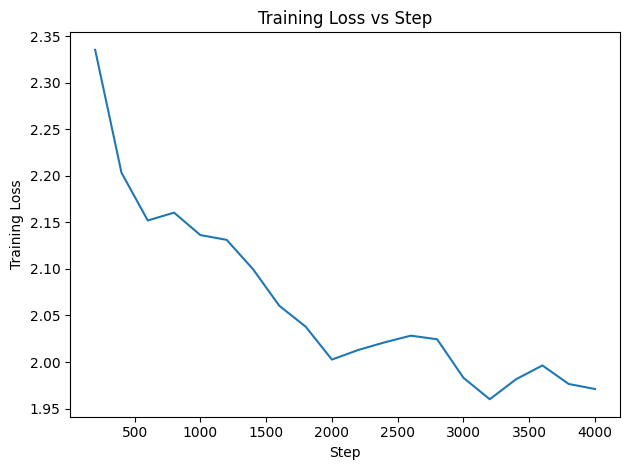

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import math

# 0️⃣ Trainer zaten tanımlı olmalı:
#    trainer = Trainer(...)

# 1️⃣ Log geçmişini al, DataFrame’e dönüştür
logs = trainer.state.log_history
df = pd.DataFrame(logs)

# 2️⃣ Training Loss vs Step
train_df = df[df['loss'].notna()]
plt.figure()
plt.plot(train_df['step'], train_df['loss'])
plt.xlabel('Step')
plt.ylabel('Training Loss')
plt.title('Training Loss vs Step')
plt.tight_layout()
plt.show()